In [1]:
# default_exp model.classifier

# Building Classifier

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#export
import os
import pandas as pd
from sample_project import config
from sample_project.helper import write_to_csv, read_from_csv
from fastcore.utils import store_attr
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc,accuracy_score,f1_score,roc_auc_score, classification_report, confusion_matrix, roc_curve
from sample_project.model import train_test_split as tts 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [4]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [5]:
#export
class Classifier:
    '''
    This class builds classifier and makes predictions for both train and test set
    Args:
            model (classifier): The classifer method with must parameters
            parameter_ranges (dict): It includes parameters together with ranges to be searched in RandomSearchCv
            scaling (boolean): If scaling is necessary before training, then "True"
            n_iter (integer): The loan dataset which has at least these fields: "client_id","amount"
            scoring (string): Loan amount threshold to be use to apply filter 2
            seed (integer): District count threshold to be used to apply filter 3
            train (pandas dataframe): train set contains client_id as primary key + features + label (churn_or_not) 
            test (pandas dataframe): train set contains client_id as primary key + features + label (churn_or_not)

        Return:
            train_result (pandas DataFrame): result data which includes predicted, actual and probability for being 1 for train
            test_result (pandas DataFrame): result data which includes predicted, actual and probability for being 1 for test
    
        '''
        
    def __init__(self, model=None, parameter_ranges=None, scaling=True, n_iter=10, scoring="f1",seed=1):
        
        store_attr()
        
        if model == None: 
            self.model = LogisticRegression(class_weight="balanced",max_iter=1000)
        
        if parameter_ranges ==None:
            self.parameter_ranges = {"penalty": ["l1","l2"], "C" : np.arange(0.01,10,0.1)}
            
    def __call__(self, train=None, test=None):
        
        if (train == None) & (test == None):
            splitter = tts.Stratified_Split()
            train,test = splitter()
        
        self.x_train = train.drop(["churn_or_not","client_id"],axis=1)
        self.y_train = train.churn_or_not
        
        self.x_test = test.drop(["churn_or_not","client_id"],axis=1)
        self.y_test = test.churn_or_not
        
        if self.scaling:
            self._scaler()
        
        self._fit_with_randomsearchcv()
        
        train_pred, test_pred = self._make_prediction()
        
        train_pred_proba, test_pred_proba = self._make_prediction()
        
        train_result = pd.DataFrame()
        train_result["truth"] = self.y_train
        train_result["pred"] = train_pred
        train_result["prob"] = train_pred_proba
       
        test_result = pd.DataFrame()
        test_result["truth"] = self.y_test
        test_result["pred"] = test_pred
        test_result["prob"] = test_pred_proba
        
        
        return train_result, test_result
        
    def _scaler(self):
        
        scaler = StandardScaler()
        self.x_train = scaler.fit_transform(self.x_train)
        self.x_test = scaler.transform(self.x_test)
        return
    
    def _fit_with_randomsearchcv(self):
        
        cv = RandomizedSearchCV(self.model, self.parameter_ranges, scoring = self.scoring, n_iter = self.n_iter, 
                                random_state=self.seed, verbose=1)
        search_fit = cv.fit(self.x_train,self.y_train)
        
        self.selected_fit = search_fit.best_estimator_
        return
    
    def _make_prediction(self):
        return self.selected_fit.predict(self.x_train), self.selected_fit.predict(self.x_test)
    
    def _forecast_probabilities(self):
        return self.selected_fit.predict_proba(self.x_train)[:, 1], self.selected_fit.predict_proba(self.x_test)[:, 1]
    

In [6]:
#export
def show_performance(result, conf_matrix = True, Report = True, Auc_roc = True):
    '''
    Args:
        result (pandas): The result dataframe contains predicted & actual label together with prob. of being label 1

    '''
    if Report:
        print(classification_report(result.truth,result.pred))
    
    if conf_matrix:
        cm = confusion_matrix(result.truth,result.pred)
        plot_confusion_matrix(cm)
        
    if Auc_roc:
        
        auc = roc_auc_score(result.truth,result.prob)
        print('AUC: %.2f' % auc)
        fpr, tpr, thresholds = roc_curve(result.truth,result.prob)
        plot_roc_curve(fpr, tpr)
    
    return

In [7]:
#export
def plot_confusion_matrix(cm):
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    plt.show()
    return

In [8]:
#export
def plot_roc_curve(fpr, tpr):
    ax= plt.subplot()
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Logistic Regressor

In [9]:
#hide
classifier  = Classifier()
train_result, test_result =  classifier()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


              precision    recall  f1-score   support

           0       0.93      0.58      0.72       566
           1       0.10      0.53      0.17        49

    accuracy                           0.58       615
   macro avg       0.52      0.56      0.44       615
weighted avg       0.87      0.58      0.67       615



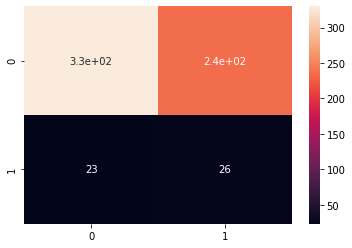

AUC: 0.56


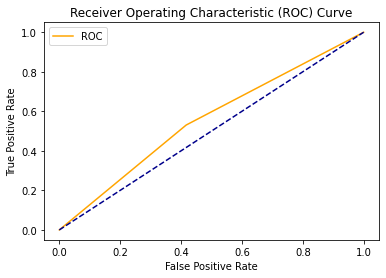

In [10]:
#hide
show_performance(train_result, conf_matrix = True, Report = True, Auc_roc = True)

              precision    recall  f1-score   support

           0       1.00      0.53      0.69        64
           1       0.14      1.00      0.25         5

    accuracy                           0.57        69
   macro avg       0.57      0.77      0.47        69
weighted avg       0.94      0.57      0.66        69



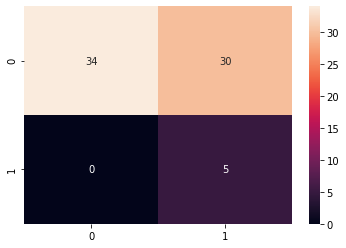

AUC: 0.77


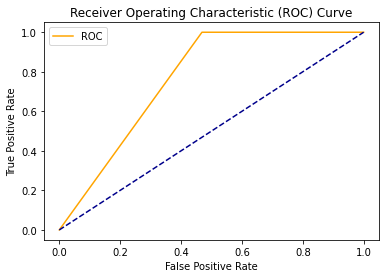

In [11]:
#hide
show_performance(test_result, conf_matrix = True, Report = True, Auc_roc = True)

## Random Forest Classifier

In [12]:
#hide
model = RandomForestClassifier(class_weight="balanced")
parameter_ranges = {"n_estimators":np.arange(10,100,20), "max_depth":np.arange(2,10,3),"ccp_alpha":np.arange(0,1,0.20)}
classifier  = Classifier(model=model, parameter_ranges = parameter_ranges, scaling=False)
train_result, test_result = classifier()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       566
           1       0.90      0.73      0.81        49

    accuracy                           0.97       615
   macro avg       0.94      0.86      0.90       615
weighted avg       0.97      0.97      0.97       615



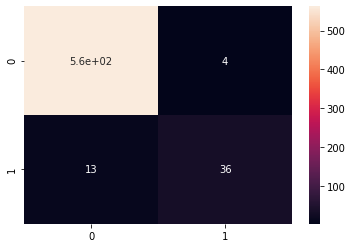

AUC: 0.86


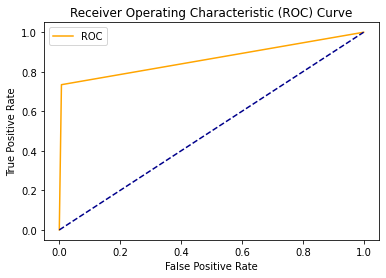

In [13]:
#hide
show_performance(train_result, conf_matrix = True, Report = True, Auc_roc = True)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        64
           1       0.00      0.00      0.00         5

    accuracy                           0.90        69
   macro avg       0.46      0.48      0.47        69
weighted avg       0.86      0.90      0.88        69



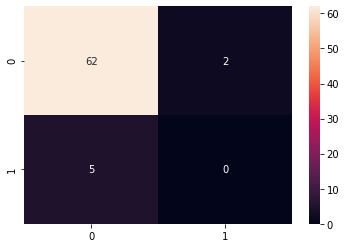

AUC: 0.48


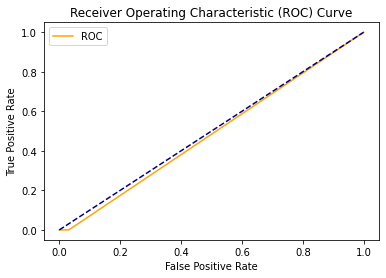

In [15]:
#hide
show_performance(test_result, conf_matrix = True, Report = True, Auc_roc = True)